In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [21]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

对马鞍山数据集划分训练集和测试集

In [22]:
df_suzhou=pd.read_excel("./data/宿州.xlsx")
df_suzhou['日期'] = pd.to_datetime(df_suzhou['日期'])
X1_suzhou=df_suzhou.drop(columns=['平均负荷','碳排放强度', '日期','机组'])
y1_suzhou=df_suzhou['碳排放强度']

df_anqing=pd.read_excel("./data/安庆12.xlsx")
df_anqing['日期'] = pd.to_datetime(df_suzhou['日期'])
X1_anqing=df_suzhou.drop(columns=['平均负荷','碳排放强度', '日期','机组'])
y1_anqing=df_suzhou['碳排放强度']

df_maanshan=pd.read_excel("./data/马鞍山.xlsx")
df_maanshan['日期'] = pd.to_datetime(df_maanshan['日期'])
X1 = df_maanshan.drop(columns=['平均负荷','碳排放强度','排汽温度', '日期'])
y1 = df_maanshan['碳排放强度']

# 特征缩放
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
scaler5 = MinMaxScaler()
scaler6 = MinMaxScaler()
X1_suzhou_scaled = scaler1.fit_transform(X1_suzhou)
y1_suzhou_scaled = scaler2.fit_transform(y1_suzhou.to_frame())
X1_anqing_scaled = scaler5.fit_transform(X1_anqing)
y1_anqing_scaled = scaler6.fit_transform(y1_anqing.to_frame())
X1_scaled = scaler3.fit_transform(X1)
y1_scaled = scaler4.fit_transform(y1.to_frame())

y1_suzhou_scaled=pd.Series(y1_suzhou_scaled.flatten())
y1_anqing_scaled=pd.Series(y1_anqing_scaled.flatten())
y1_scaled=pd.Series(y1_scaled.flatten())

# 训练集：宿州数据+80%马鞍山数据，测试集：20%马鞍山数据
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_scaled, test_size=0.3, random_state=42)
X1_train=np.vstack((X1_suzhou_scaled,X1_anqing_scaled,X1_train))
y1_train=np.hstack((y1_suzhou_scaled,y1_anqing_scaled,y1_train))
y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))

排序的特征重要性

In [23]:
def plot_feature_importance(feature_importances):
    sorted_idx = np.argsort(feature_importances)  # 获取按重要性排序的索引
    sorted_feature_names = np.array(X1.columns)[sorted_idx]  # 排序后的特征名
    sorted_feature_importances = feature_importances[sorted_idx]  # 排序后的特征重要性
    sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性
    # 可视化特征重要性和正反相关性
    plt.figure(figsize=(10, 8))
    bars = plt.barh(sorted_feature_names, sorted_feature_importances,height = 0.6,color=np.where(sorted_correlations > 0, '#CA7373', '#4874CB'))
    # 设置y轴标签的字体粗细
    plt.yticks(fontsize=13, fontweight='bold')
    plt.xticks(fontsize=13, fontweight='bold')
    plt.xlabel("特征重要性", fontsize=13, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

预测结果图

In [24]:
def plot_line(pred):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines  # 导入 mlines
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 绘制test data预测值和真实值
    plt.figure(figsize=(18, 9))
    plt.plot(pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
    plt.plot(y1_test_recover, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
    # 绘制test data的预测值和真实值
    plt.scatter(range(len(pred)), pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
    plt.scatter(range(len(y1_test_recover)), y1_test_recover, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
    # 创建自定义的图例（线+点）
    line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
    line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")
    
    # 显示图例
    plt.legend(handles=[line1, line2], fontsize=12.5)
    plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
    plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')
    
    # 显示图表
    plt.tight_layout()  # 调整布局，确保所有元素不重叠
    # plt.savefig("rf1.png",dpi=500,bbox_inches='tight')
    plt.show()

预测值与真实值对比

In [25]:
def plot_compare_line(pred,r2):
    # 计算线性回归拟合系数
    z = np.polyfit(y1_test_recover.T[0], pred, 1)  # 线性拟合
    p = np.poly1d(z)  # 得到拟合的多项式函数
    # 计算拟合值
    y_fit = p(y1_test_recover.T[0])
    # 计算残差
    residuals = pred - y_fit
    # 计算标准误差
    std_err = np.std(residuals)
    # 计算95%置信区间
    confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96
    # 使用 pandas DataFrame 排序
    data = pd.DataFrame({'y_test': y1_test_recover.T[0], 'y_pred': pred, 'y_fit': y_fit})
    # 按 'y_test' 升序排序
    data_sorted = data.sort_values(by='y_test')
    # 提取排序后的值
    sorted_y_test = data_sorted['y_test'].values
    sorted_y_pred = data_sorted['y_pred'].values
    sorted_y_fit = data_sorted['y_fit'].values
    # 绘制散点图，x轴为实际值，y轴为预测值
    plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='数据点')
    # 绘制拟合线
    plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"拟合线\n$R^2$ = {r2:.2f}")
    # 绘制95%置信区间阴影区域
    plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.2, label='95% 置信区间')
    # 添加y=x的参考线，用于比较预测值与实际值的吻合度
    max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
    min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x 参考线')  # 画出y=x的对角线
    # 图表标题和标签
    plt.title("模型预测与实际值比较")
    plt.xlabel("碳排放强度实际值/(g/kWh)", fontsize=12)
    plt.ylabel("碳排放强度预测值/(g/kWh)", fontsize=12)
    # 显示图例
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

1.SVM

In [26]:
# 创建并训练SVR模型
svr_model = SVR(gamma=0.005,C=4600,epsilon=0.09)
svr_model.fit(X1_train, y1_train)
# 进行预测
svm_y_pred = svr_model.predict(X1_test)

svm_y_pred=scaler4.inverse_transform(pd.DataFrame({'pred':svm_y_pred}))
y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
# 评估模型
svm_mse = mean_squared_error(y1_test_recover, svm_y_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(y1_test_recover, svm_y_pred)
svm_mape = mean_absolute_percentage_error(y1_test_recover, svm_y_pred)
svm_r2 = r2_score(y1_test_recover, svm_y_pred)

print(f"svm_MSE: {svm_mse:.6f}")
print(f"svm_RMSE: {svm_rmse:.6f}")
print(f"svm_MAE: {svm_mae:.6f}")
print(f"svm_MAPE: {svm_mape*100:.6f}")
print(f"svm_R Square: {svm_r2:.6f}")

svm_MSE: 15853.783590
svm_RMSE: 125.911809
svm_MAE: 108.322748
svm_MAPE: 20.639213
svm_R Square: 0.518025


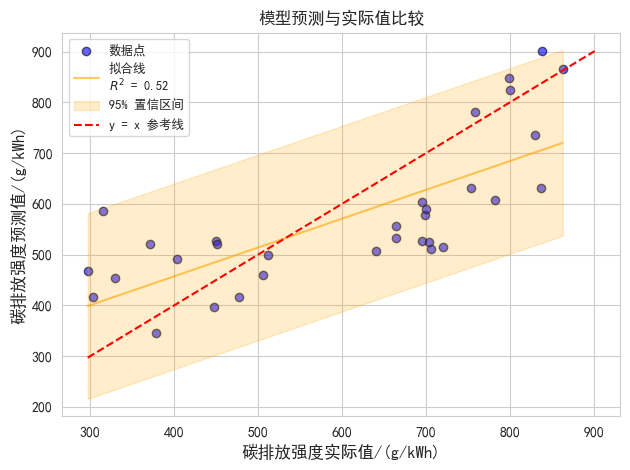

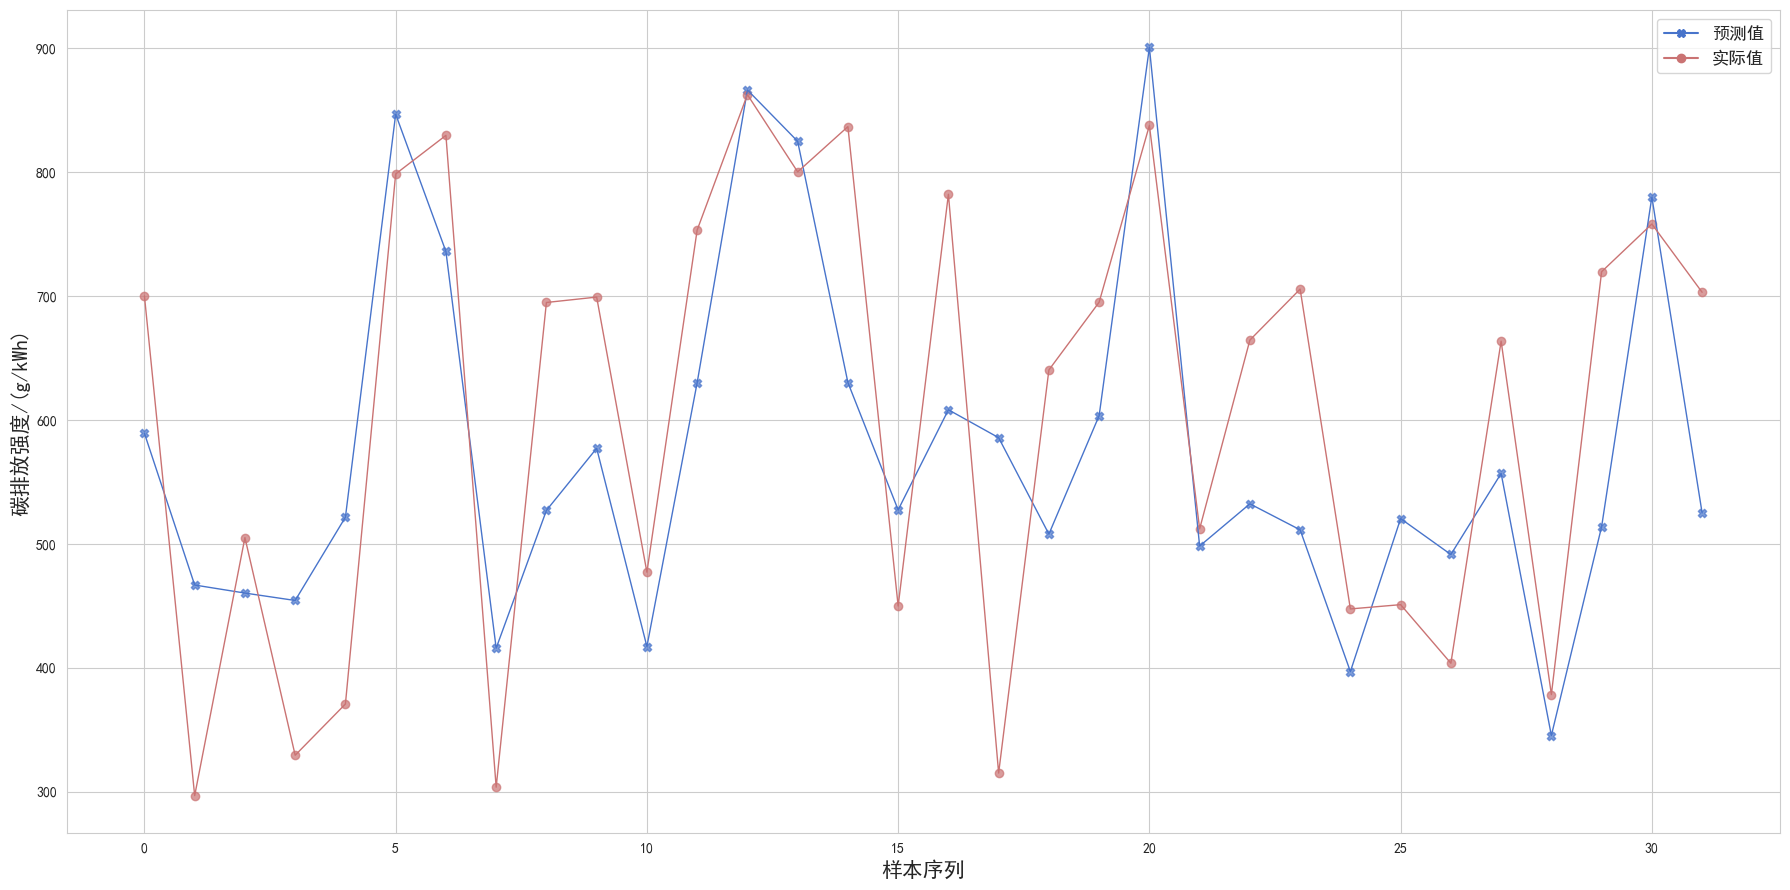

In [27]:
# plot_feature_importance(np.abs(svr_model.coef_).flatten())
plot_compare_line(svm_y_pred.T[0],svm_r2)
plot_line(svm_y_pred)

2.RF

In [28]:
correlation_matrix = df_maanshan.drop(columns=['排汽温度', '日期']).corr()
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_jobs=28,max_depth=26,n_estimators=178,random_state=42)
rf_model.fit(X1_train, y1_train)
rf_y1_pred = rf_model.predict(X1_test)

rf_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':rf_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))

rf_mse = mean_squared_error(y1_test_recover, rf_y1_pred)
rf_rmse = np.sqrt(rf_mse)  # Calculating RMSE
rf_mae = mean_absolute_error(y1_test_recover, rf_y1_pred)
rf_mape = mean_absolute_percentage_error(y1_test_recover, rf_y1_pred)
rf_r2 = r2_score(y1_test_recover, rf_y1_pred)

print(f"rf_MSE: {rf_mse:.6f}")
print(f"rf_RMSE: {rf_rmse:.6f}")
print(f"rf_MAE: {rf_mae:.6f}")
print(f"rf_MAPE: {rf_mape*100:.6f}")
print(f"rf_R Square: {rf_r2:.6f}")

rf_MSE: 19240.157701
rf_RMSE: 138.708896
rf_MAE: 112.737052
rf_MAPE: 21.530061
rf_R Square: 0.415075


C:\Users\97112\AppData\Local\Temp\ipykernel_34940\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


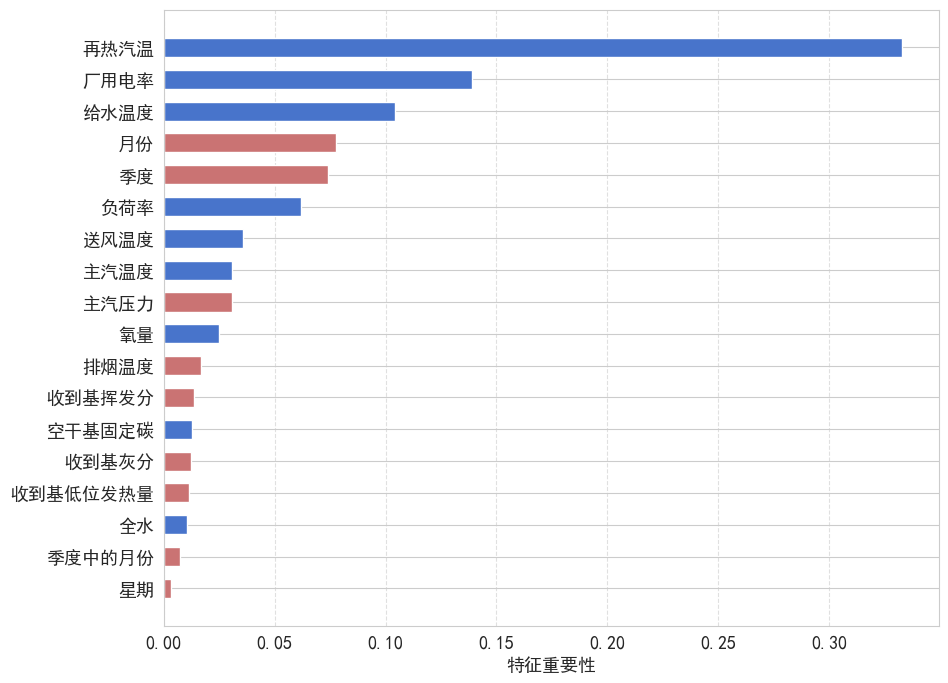

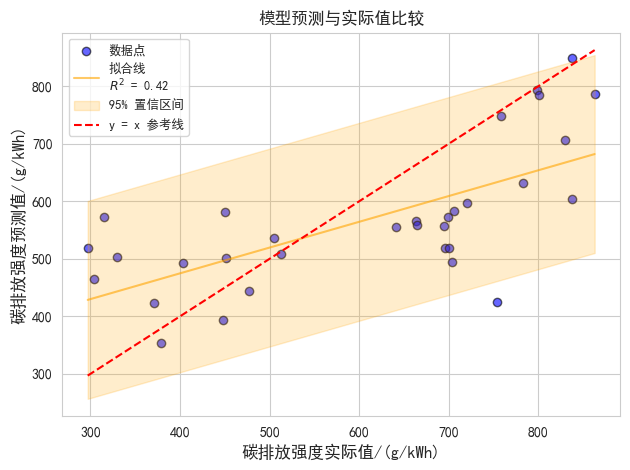

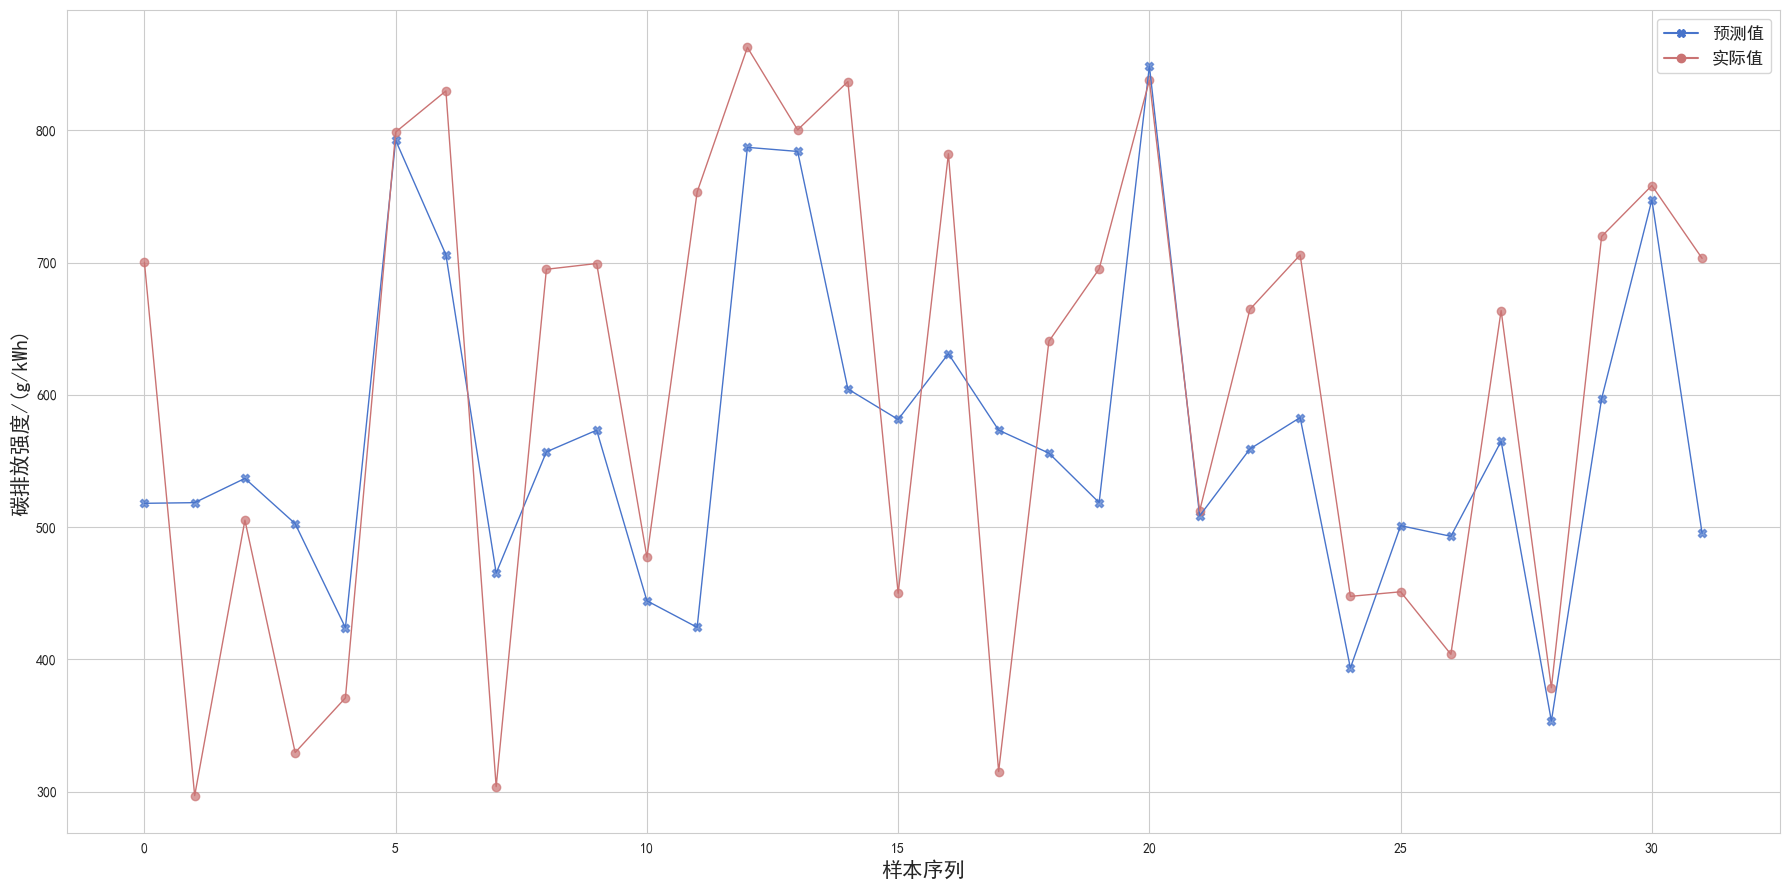

In [29]:
plot_feature_importance(rf_model.feature_importances_)
plot_compare_line(rf_y1_pred.T[0],rf_r2)
plot_line(rf_y1_pred)

3.XGB

In [30]:
from xgboost import XGBRegressor
# 初始化XGBoost回归器
xgb_model = XGBRegressor(
    n_estimators=48,        # 树的数量
    max_depth=7,             # 树的最大深度
    learning_rate=0.1,       # 学习率
    subsample=0.8,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    random_state=42
)
# 训练模型
xgb_model.fit(X1_train, y1_train)
# Predict on the test set
xgb_y1_pred =  xgb_model.predict(X1_test)
xgb_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':xgb_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
# Evaluate the model
xgb_mse = mean_squared_error(y1_test_recover, xgb_y1_pred)
xgb_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
xgb_mae = mean_absolute_error(y1_test_recover, xgb_y1_pred)
xgb_mape = mean_absolute_percentage_error(y1_test_recover, xgb_y1_pred)
xgb_r2 = r2_score(y1_test_recover, xgb_y1_pred)
print(f"xgb_MSE: {xgb_mse:.6f}")
print(f"xgb_RMSE: {xgb_rmse:.6f}")
print(f"xgb_MAE: {xgb_mae:.6f}")
print(f"xgb_MAPE: {xgb_mape*100:.6f}")
print(f"xgb_R Square: {xgb_r2:.6f}")

xgb_MSE: 20980.422817
xgb_RMSE: 144.846204
xgb_MAE: 117.982489
xgb_MAPE: 21.958022
xgb_R Square: 0.362169


C:\Users\97112\AppData\Local\Temp\ipykernel_34940\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


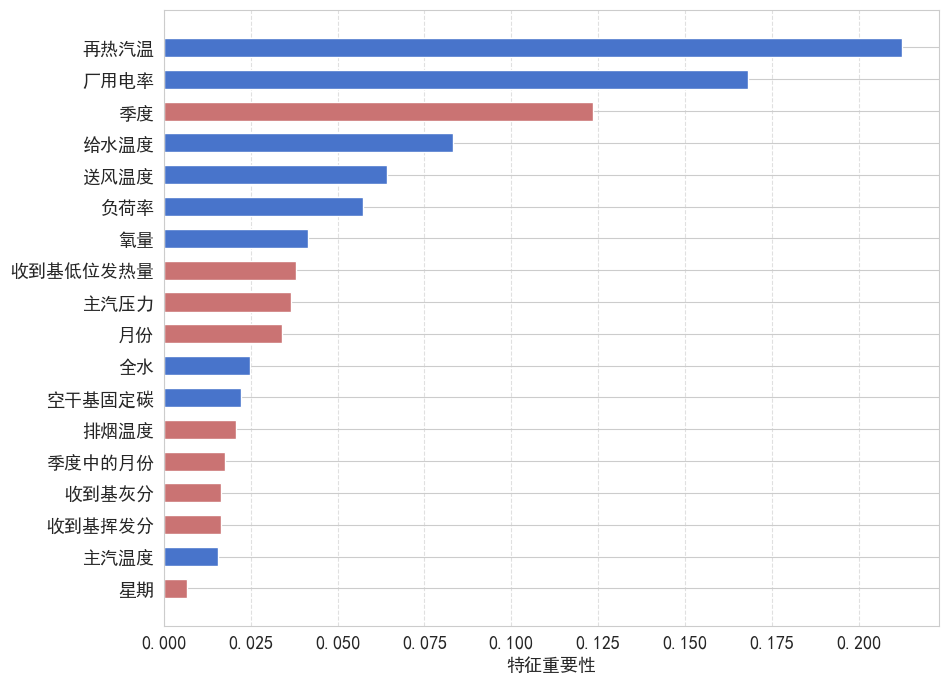

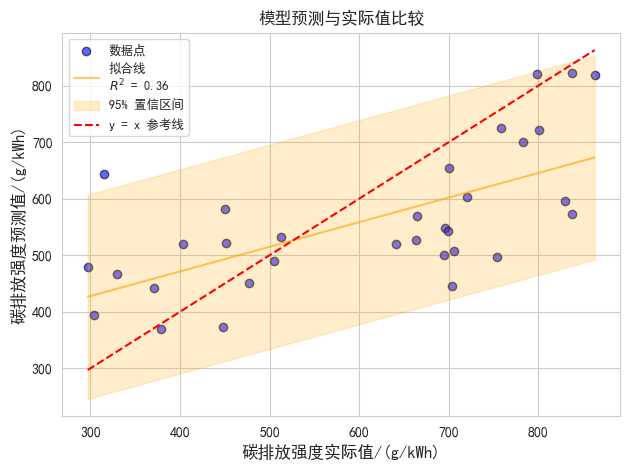

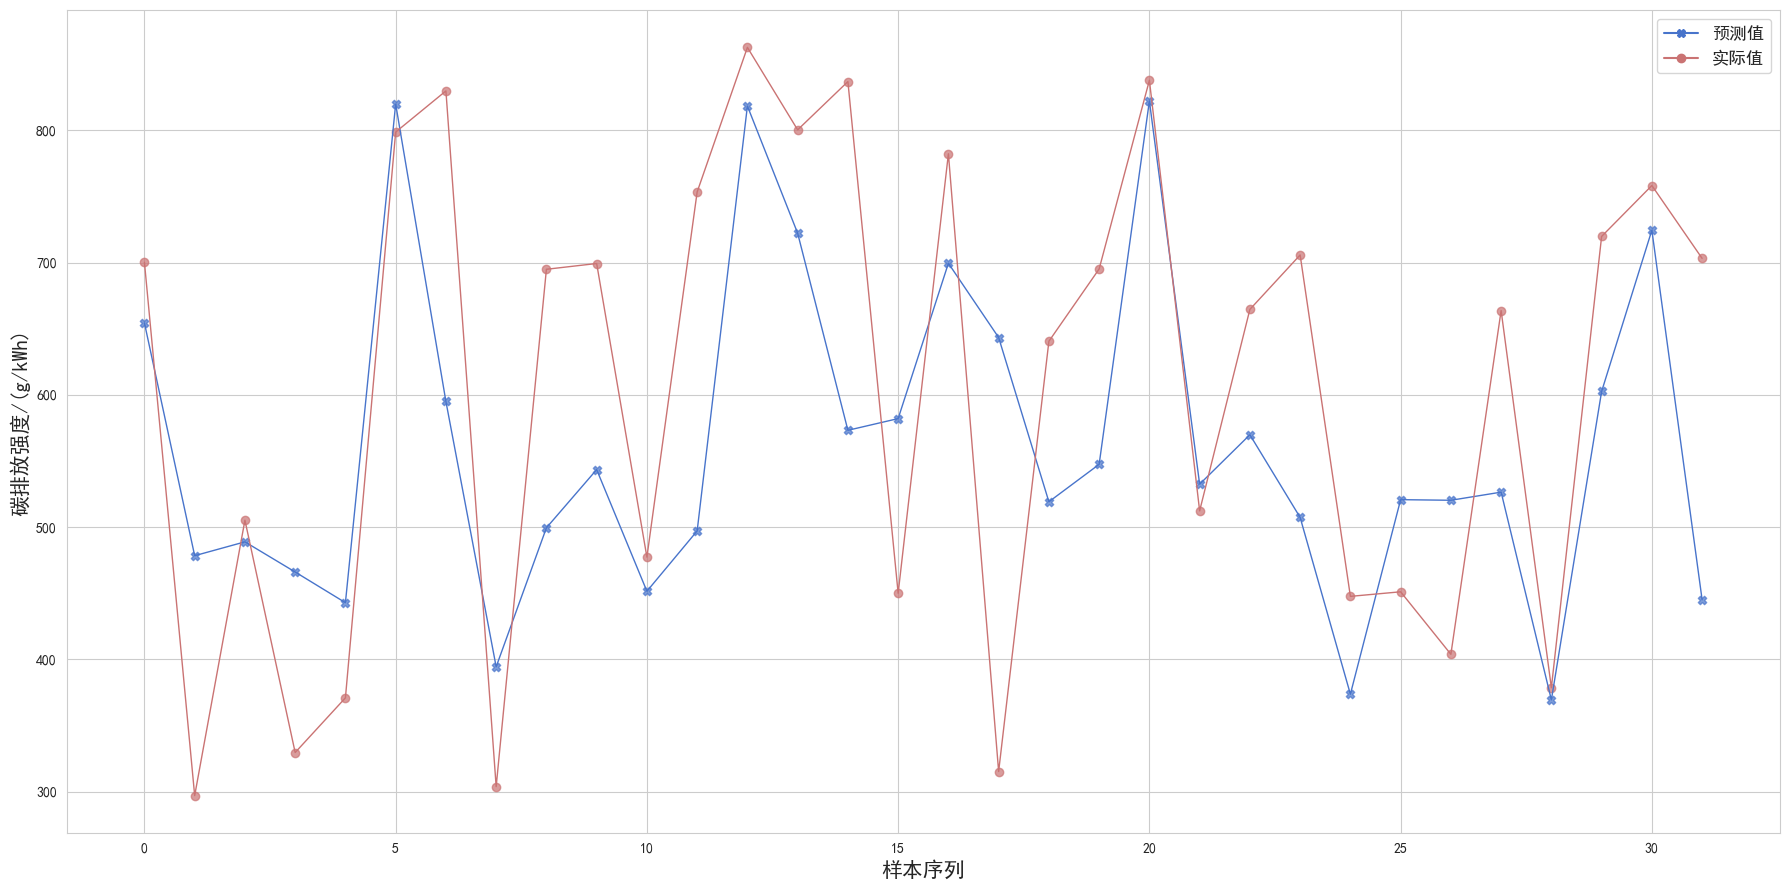

In [31]:
plot_feature_importance(xgb_model.feature_importances_)
plot_compare_line(xgb_y1_pred.T[0],xgb_r2)
plot_line(xgb_y1_pred)

4.LR

In [32]:
from sklearn.linear_model import LinearRegression
# 创建线性回归模型
linear_model = LinearRegression()
# 拟合模型
linear_model.fit(X1_train, y1_train)
# 在测试集上进行预测
linear_y1_pred = linear_model.predict(X1_test)
linear_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':linear_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
lr_mse = mean_squared_error(y1_test_recover, linear_y1_pred)
lr_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
lr_mae = mean_absolute_error(y1_test_recover, linear_y1_pred)
lr_mape = mean_absolute_percentage_error(y1_test_recover, linear_y1_pred)
lr_r2 = r2_score(y1_test_recover, linear_y1_pred)
print(f"lr_MSE: {lr_mse:.6f}")
print(f"lr_RMSE: {lr_rmse:.6f}")
print(f"lr_MAE: {lr_mae:.6f}")
print(f"lr_MAPE: {lr_mape*100:.6f}")
print(f"lr_R Square: {lr_r2:.6f}")
print(f"回归系数: {linear_model.coef_}")
print(f"截距: {linear_model.intercept_}")

lr_MSE: 23013.351898
lr_RMSE: 144.846204
lr_MAE: 129.481698
lr_MAPE: 23.019342
lr_R Square: 0.300366
回归系数: [-6.51401588e+10 -1.44755908e+10  7.96157496e+10  7.47036934e-03
  7.73544312e-02 -3.13531876e-01  1.05028391e-01  3.55701447e-02
 -3.56503487e-01 -1.54017448e-01  1.11430788e+00 -2.55732536e-02
 -3.97642016e-01 -1.20252132e-01 -4.27166283e-01  1.94497108e-02
  1.75666809e-03 -7.82929420e-01]
截距: 1.0128570465258502


C:\Users\97112\AppData\Local\Temp\ipykernel_34940\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


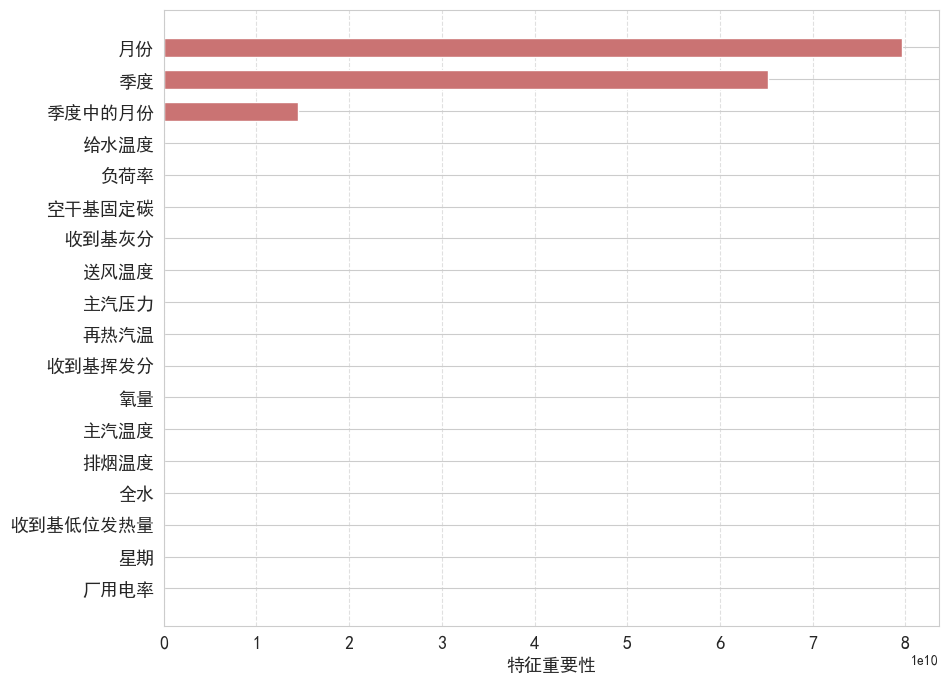

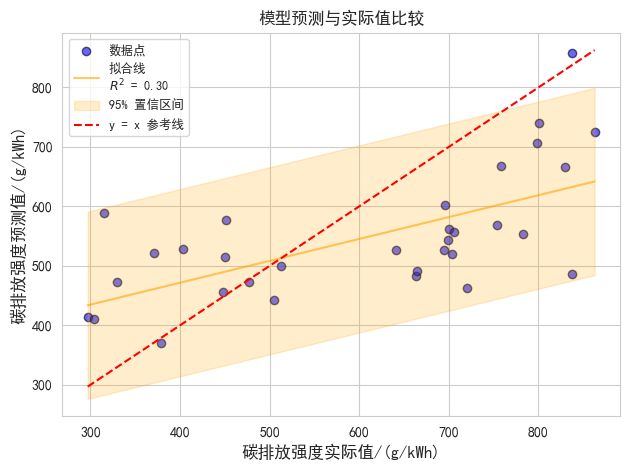

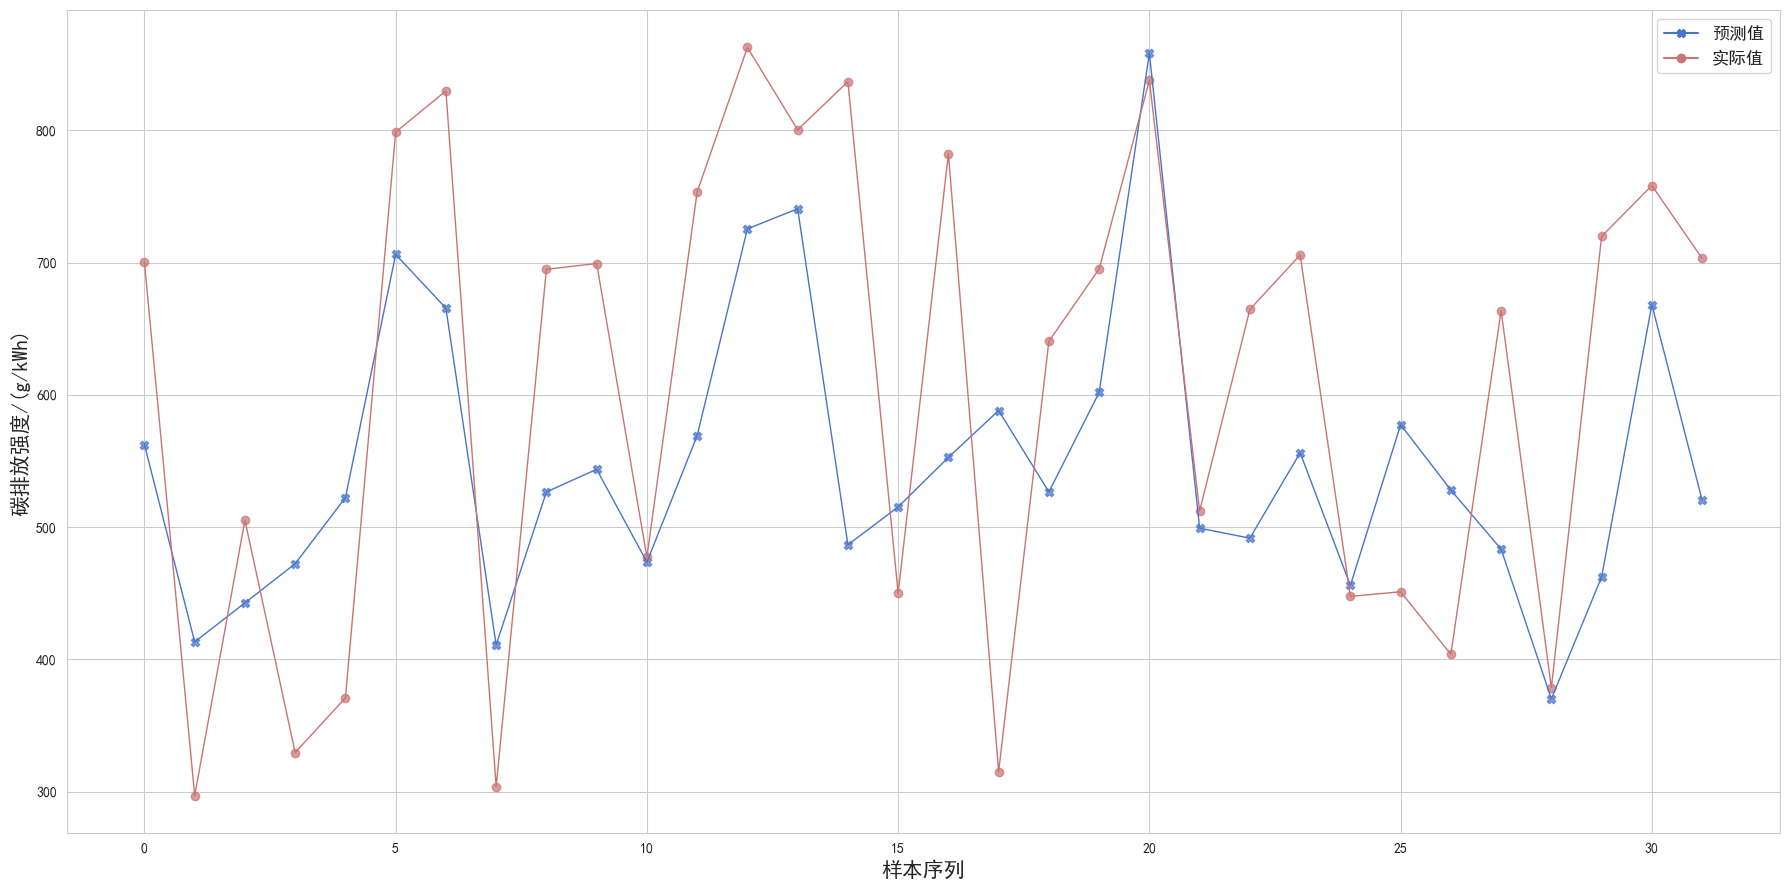

In [33]:
plot_feature_importance(np.abs(linear_model.coef_).flatten())
plot_compare_line(linear_y1_pred.T[0],lr_r2)
plot_line(linear_y1_pred)

5.DNN

In [34]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

X1_train_tensor=torch.FloatTensor(X1_train).to(device)
y1_train_tensor=torch.FloatTensor(y1_train).view(-1,1).to(device)
X1_test_tensor=torch.FloatTensor(X1_test).to(device)
y1_test_tensor=torch.FloatTensor(y1_test).view(-1,1).to(device)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 第一个隐藏层
        self.fc2 = nn.Linear(64, 32)          # 第二个隐藏层
        self.fc3 = nn.Linear(32, 1)           # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
input_size = X1_train.shape[1]
model = SimpleNN(input_size).to(device)
# 3. 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model.parameters(), lr=0.12)

# 4. 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model(X1_train_tensor)  # 前向传播
    loss = criterion(outputs, y1_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. 评估模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    predictions = model(X1_test_tensor)  # 预测
    test_loss = criterion(predictions, y1_test_tensor)  # 计算测试损失
    print(f'Test Loss: {test_loss.item():.4f}')

predictions=predictions.cpu().numpy().flatten()
predictions=scaler4.inverse_transform(pd.DataFrame({'pred':predictions}))
# Evaluate the model
dnn_mse = mean_squared_error(y1_test_recover, predictions)
dnn_rmse = np.sqrt(dnn_mse)  # Calculating RMSE
dnn_mae = mean_absolute_error(y1_test_recover, predictions)
dnn_mape = mean_absolute_percentage_error(y1_test_recover, predictions)
dnn_r2 = r2_score(y1_test_recover, predictions)
print(f"dnn_MSE: {dnn_mse:.6f}")
print(f"dnn_RMSE: {dnn_rmse:.6f}")
print(f"dnn_MAE: {dnn_mae:.6f}")
print(f"dnn_MAPE: {dnn_mape*100:.6f}")
print(f"dnn_R Square: {dnn_r2:.6f}")

Epoch [1000/10000], Loss: 0.0102
Epoch [2000/10000], Loss: 0.0079
Epoch [3000/10000], Loss: 0.0066
Epoch [4000/10000], Loss: 0.0058
Epoch [5000/10000], Loss: 0.0054
Epoch [6000/10000], Loss: 0.0050
Epoch [7000/10000], Loss: 0.0050
Epoch [8000/10000], Loss: 0.0048
Epoch [9000/10000], Loss: 0.0042
Epoch [10000/10000], Loss: 0.0040
Test Loss: 0.0363
dnn_MSE: 16614.122132
dnn_RMSE: 128.895780
dnn_MAE: 112.672680
dnn_MAPE: 20.359226
dnn_R Square: 0.494910


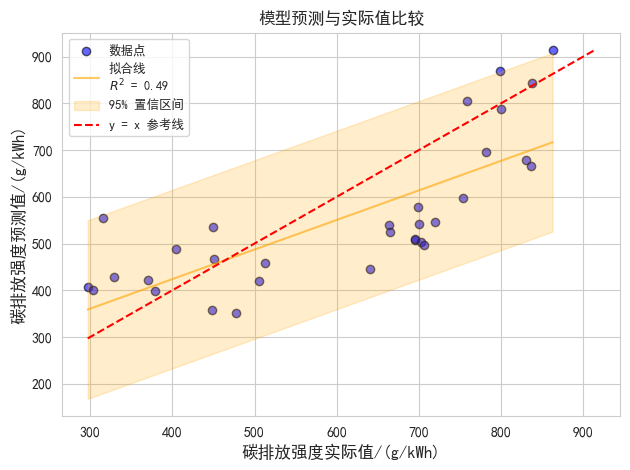

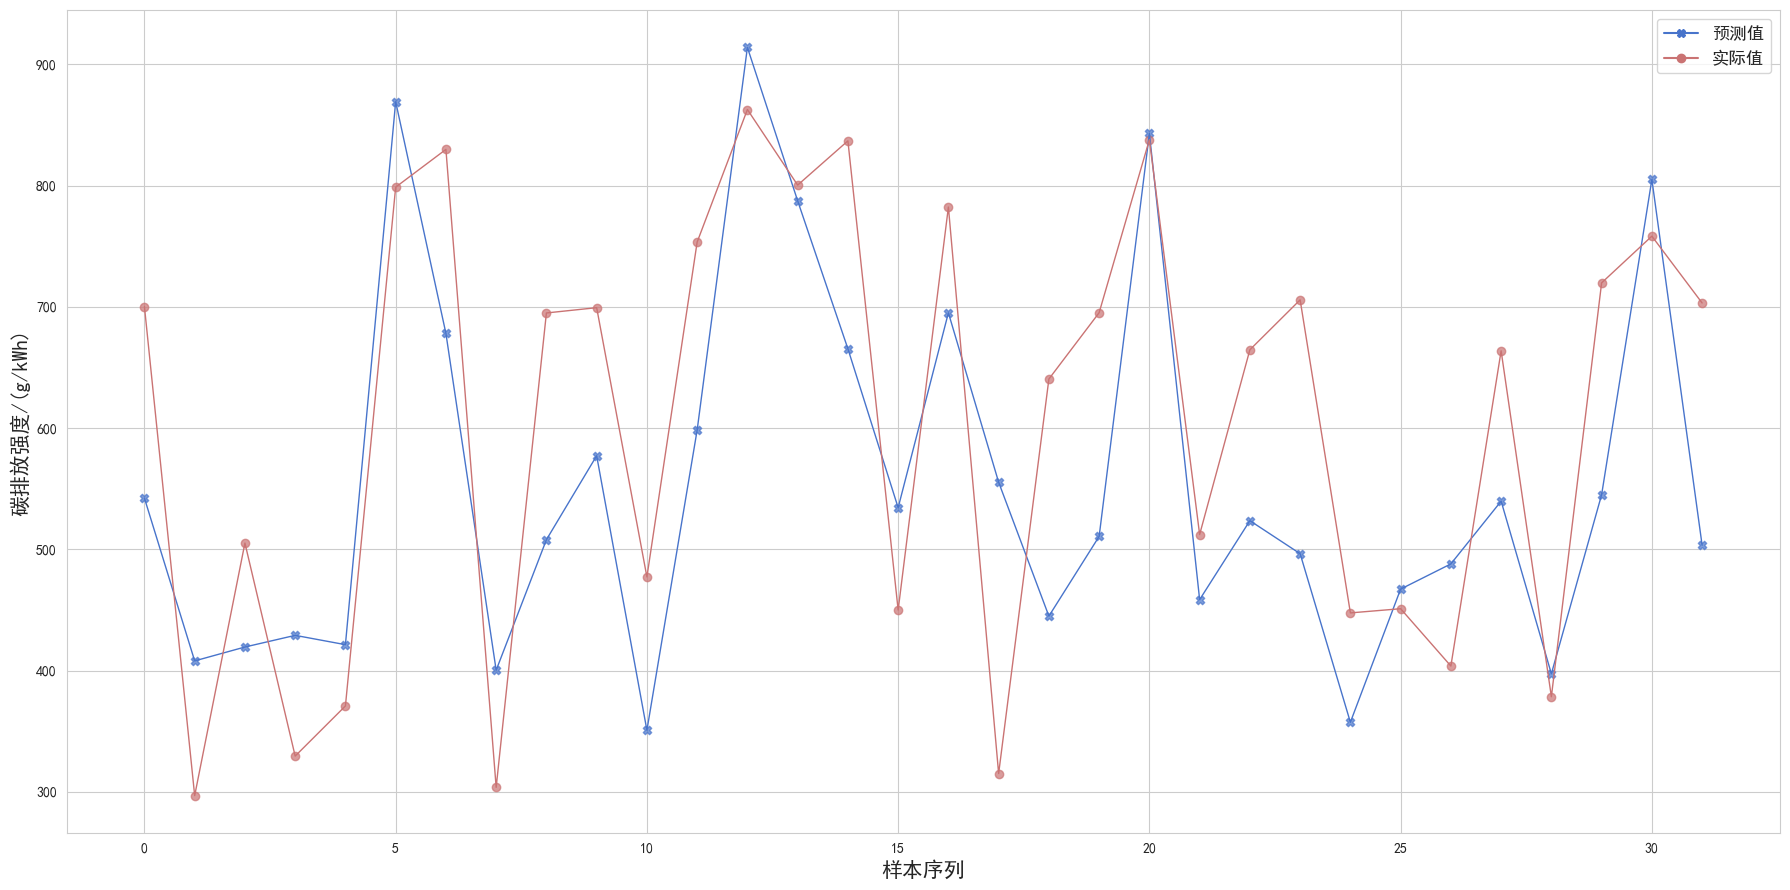

In [35]:
# plot_feature_importance(model.)
plot_compare_line(predictions.T[0],dnn_r2)
plot_line(predictions)